# Part 1. Preprocessing fMRI data using `fmriprep` and `Nipype`

In this notebook we will preprocess fMRI data. We will explore two options for preprocessing:
1. Using [`fmriprep`](http://fmriprep.readthedocs.io/), a pipeline developed by the Poldrack lab
2. Building your own pipeline using [`Nipype`](https://nipype.readthedocs.io/en/latest/)

Nipype is a pipelining tool that makes it easy to share pipelines of fMRI preprocessing, as well as document them, and run (them in parallel on a cluster). In fact, `fmriprep` makes use of `Nipype`.

First we import libraries that contain useful functions

In [10]:
import nipype                    # Nipype is a pipelining tool
import nibabel as nib            # Nibabel is a library to read in nifti-files
import numpy as np               # Numpy is 'matlab for Python'
import matplotlib.pyplot as plt  # Matplotlib is a plotting library
import seaborn as sns            # Seaborn is an extension to matplotlib, that offers 
                                 # convenience wrappers and nicer looking plots

import os                        # Useful for directory specification later on

# This (obscure) line of code causes figures to be plotted in line with the notebook
%matplotlib inline

## 1. Load and visualize data
First, let's have a look at what the data actually look like. Below, we load the functional data of a single subject and a single run

In [2]:
hdr = nib.load('/data/bids/sub-197/func/sub-197_task-SAT_run-1_bold.nii.gz')
data = hdr.get_data()

Now `data` is a numpy-array: a matlab-like matrix, that is efficiently stored in memory, and can be accessed fast using pointers.

##### 1. What is the size of this matrix ([hint](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html))?

The last dimension is _time_, that is, there are:

volumes in this run.

##### 2. Try to average the data over the time-dimension ([hint](http://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html))

In [3]:
mean_data = data.mean(axis=3)
mean_data.shape

(64, 80, 33)

This `mean_data` variable is now a 3D-matrix containing the mean signal in each voxel. Let's try to visualize this. You can now use the following code to make an image

(-0.5, 63.5, -0.5, 32.5)

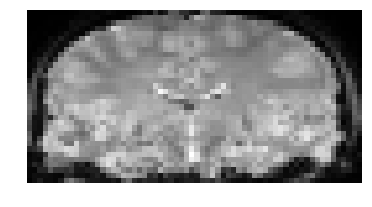

In [4]:
plt.imshow(mean_data[:, 40, :,].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')

This is a 'coronal' slice. 

##### 3. Can you edit the code to make an _axial_ slice?

(-0.5, 63.5, -0.5, 79.5)

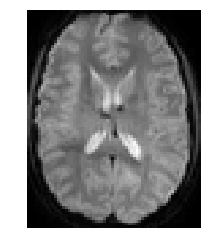

In [5]:
plt.imshow(mean_data[:, :, 15,].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')

Let's also inspect the changes in voxel intensity over time.

Text(0,0.5,'Intensity')

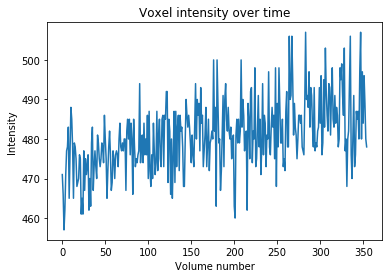

In [6]:
# We can plot like this
plt.plot(data[32, 40, 20, :])
plt.title('Voxel intensity over time')
plt.xlabel('Volume number')
plt.ylabel('Intensity')

In the image above, you can see a gradual increase in signal over time. This drift is generally removed in preprocessing by applying a high-pass filter

##### 4. Calculate the total amount of time between the first and last volumes. Note that the repetition time (time between volumes) is 1.994s.

In [7]:
data.shape[3] * 1.994

707.87

## 2. Using `fmriprep`
`fmriprep` is a package developed by the Poldrack lab to do the minimal of preprocessing required. It covers motion correction, field unwarping, registration, and brain extraction. It uses a combination of well-known software packages (e.g., FSL, SPM, ANTs, AFNI) and selects the 'best' implementation of each preprocessing step.

Once installed, `fmriprep` can be invoked from the command line. One nice feature of IPython Notebooks (i.e., the thing in your browser you're right now looking at) is that you can invoke command line commands with an `!`, like this:

In [8]:
!ls /data/bids

behavior.tsv		  sub-381  sub-523  sub-551  sub-555
dataset_description.json  sub-471  sub-544  sub-552  sub-558
sub-197			  sub-483  sub-548  sub-553  sub-559
sub-372			  sub-498  sub-549  sub-554  task-SAT_bold.json


To visualize the full data structure, you can use `tree`:

In [9]:
!tree /data/deriv

/data/deriv
└── fmriprep
    ├── dataset_description.json
    ├── desc-aparcaseg_dseg.tsv
    ├── desc-aseg_dseg.tsv
    ├── logs
    │   ├── CITATION.bib
    │   ├── CITATION.html
    │   ├── CITATION.md
    │   └── CITATION.tex
    ├── sub-197
    │   ├── anat
    │   │   ├── sub-197_desc-aparcaseg_dseg.nii.gz
    │   │   ├── sub-197_desc-aseg_dseg.nii.gz
    │   │   ├── sub-197_desc-brain_mask.json
    │   │   ├── sub-197_desc-brain_mask.nii.gz
    │   │   ├── sub-197_desc-preproc_T1w.json
    │   │   ├── sub-197_desc-preproc_T1w.nii.gz
    │   │   ├── sub-197_dseg.nii.gz
    │   │   ├── sub-197_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5
    │   │   ├── sub-197_from-orig_to-T1w_mode-image_xfm.txt
    │   │   ├── sub-197_from-T1w_to-fsnative_mode-image_xfm.txt
    │   │   ├── sub-197_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5
    │   │   ├── sub-197_hemi-L_inflated.surf.gii
    │   │   ├── sub-197_hemi-L_midthickness.surf.gii
    │   │   ├── sub-197_hemi-L_pial.surf.gii

where `ls` is a command that shows all files and directories in a given directory (here, /data)

Since `fmriprep` is run from command line, we could run it even inside a notebook! For example, the following command should work after you remove the 'hashtag' `#`:

In [2]:
!pip install sentry_sdk

    100% |████████████████████████████████| 81kB 11.0MB/s ta 0:00:01
You are using pip version 9.0.3, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!fmriprep --output-spaces MNI152NLin2009cAsym --use-syn --fs-license-file=../license.txt /data/bids /data/output_folder participant

Making sure the input data is BIDS compliant (warnings can be ignored in most cases).
bids-validator does not appear to be installed
Although ``--fs-no-reconall`` was not set (i.e., FreeSurfer is to be run), no FreeSurfer output space (valid values are: fsaverage5, fsaverage6, fsnative, fsaverage) was selected. Adding default "fsaverage5" to the list of output spaces.
190802-06:52:29,380 nipype.workflow IMPORTANT:
	 
    Running fMRIPREP version 1.4.1:
      * BIDS dataset path: /data/bids.
      * Participant list: ['197', '372', '381', '471', '483', '498', '523', '544', '548', '549', '551', '552', '553', '554', '555', '558', '559'].
      * Run identifier: 20190802-065229_466d44bc-41b7-4904-b9cf-5fba443bad5c.
    
31.6kB [00:02, 15.7kB/s]                                                        
2.53kB [00:00, 3.46kB/s]                                                        
259B [00:00, 819B/s]                                                            
190802-06:52:36,376 nipype.work

190802-06:53:38,561 nipype.workflow IMPORTANT:
	 Creating bold processing workflow for "/data/bids/sub-498/func/sub-498_task-SAT_run-1_bold.nii.gz" (0.06 GB / 355 TRs). Memory resampled/largemem=0.22/0.42 GB.
190802-06:53:38,562 nipype.workflow IMPORTANT:
	 No single-band-reference found for sub-498_task-SAT_run-1_bold.nii.gz
190802-06:53:39,128 nipype.workflow WARNING:
	 SDC: no fieldmaps found or they were ignored. Using EXPERIMENTAL "fieldmap-less SyN" correction for dataset /data/bids/sub-498/func/sub-498_task-SAT_run-1_bold.nii.gz.
190802-06:53:40,235 nipype.workflow IMPORTANT:
	 Creating BOLD surface-sampling workflow.
190802-06:53:43,382 nipype.workflow IMPORTANT:
	 Creating bold processing workflow for "/data/bids/sub-498/func/sub-498_task-SAT_run-2_bold.nii.gz" (0.06 GB / 355 TRs). Memory resampled/largemem=0.22/0.42 GB.
190802-06:53:43,383 nipype.workflow IMPORTANT:
	 No single-band-reference found for sub-498_task-SAT_run-2_bold.nii.gz
190802-06:53:43,937 nipype.workflow WAR

190802-06:54:56,109 nipype.workflow IMPORTANT:
	 Creating bold processing workflow for "/data/bids/sub-552/func/sub-552_task-SAT_run-2_bold.nii.gz" (0.06 GB / 355 TRs). Memory resampled/largemem=0.23/0.44 GB.
190802-06:54:56,110 nipype.workflow IMPORTANT:
	 No single-band-reference found for sub-552_task-SAT_run-2_bold.nii.gz
190802-06:54:56,655 nipype.workflow WARNING:
	 SDC: no fieldmaps found or they were ignored. Using EXPERIMENTAL "fieldmap-less SyN" correction for dataset /data/bids/sub-552/func/sub-552_task-SAT_run-2_bold.nii.gz.
190802-06:54:57,766 nipype.workflow IMPORTANT:
	 Creating BOLD surface-sampling workflow.
190802-06:55:03,801 nipype.workflow IMPORTANT:
	 Creating bold processing workflow for "/data/bids/sub-553/func/sub-553_task-SAT_run-1_bold.nii.gz" (0.07 GB / 355 TRs). Memory resampled/largemem=0.28/0.52 GB.
190802-06:55:03,802 nipype.workflow IMPORTANT:
	 No single-band-reference found for sub-553_task-SAT_run-1_bold.nii.gz
190802-06:55:04,328 nipype.workflow WAR

Cannot run fMRIPrep. Missing dependencies:
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAutomask (Interface: Automask)
	3dAu

The command above consists of the following parts:
   - "fmriprep" calls fmriprep
   - --output-spaces --output-spaces MNI152NLin2009cAsym tells fmriprep to normalize (register) data to template MNI152 version 6 (2009c)
   - --fs-license-file ../../license.txt tells fmriprep where to find the license.txt-file for freesurfer - you can ignore this
   - --fs-no-reconall tells it not to run surface reconstruction
   - --use-syn tells it to run SyN susceptibility distortion correction (this is experimental)
   - bids is the name of the folder containing the data in bids format
   - output_folder is the name of the folder where we want the preprocessed data to be stored
   - participant tells fmriprep to run only at the participant level (and not, for example, at the group level - you can forget about this)
   
The [official documentation](http://fmriprep.readthedocs.io/) contains all possible arguments you can pass.

Running fmriprep takes quite some time (I included the hashtag to prevent you from accidentally running it - you can, of course, but it won't finish today). So I did this for you in advance. The results can be found in the path `/data/deriv` (which stands for 'derivates': data derived from the original data). 

One particularly nice feature of `fmriprep` is that it generates a nice html-file that allows you to easily inspect whether all preprocessing steps went right. For example, to inspect how preprocessing went for `sub-197`, you can click [here](/view/logs/sub-197.html).

##### Have a look at the logs of preprocessing subject 197. What happened in each of the steps?

## 3. Creating your own preprocessing pipeline
The strength of `fmriprep` is arguably that it makes decisions for you, and makes things easier. However, this is also its weakness: you are dependent on the choices that others have made for you. In many cases, these choices are fine - however, when it comes to analyzing MRI-data, there is no "one size fits all". Even Russ Poldrack, as one of the main developers, mentions in his paper Scanning the Horizon (NRN 2017): "we do not believe that there will be a single
best workflow for all studies; in fact, there is direct evidence that different studies or individuals will probably benefit from different workflows". Different situations require different pipelines, and thus it is useful to be able to create your own preprocessing pipeline.

An excellent pipelining tool is `Nipype`. Unfortunately, it has a bit of a steep learning curve. Below, we superficially explore how Nipype works. A complete tutorial into Nipype is beyond the scope of today's workshop, but I hope to give you a quick overview and the right references to find your way.

### Nipype: The basics
Nipype is a _pipelining_ tool; that is, it allows you to create a pipeline (or workflow) of different steps of processing. Importantly, Nipype does not implement processing algorithms itself; rather, it serves as a wrapper for common algorithms built in FSL, SPM, ANTs, and AFNI. You can also add your own steps if you want, either coded in Python or as a command line call to another software package.

So let's make a simple pipeline

#### Step 1: Defining what you want to do
In the lecture, I mentioned that common preprocessing steps include motion correction (sometimes called 'realigning'), and spatial smoothing. Let's start with these two steps, and use FSL's algorithms to do this:

1. MCFLIRT for motion correction, 
2. IsotropicSmooth for smoothing

First, we load these MCFLIRT and IsotropicSmooth `interfaces`

In [4]:
from nipype.interfaces.fsl import MCFLIRT, IsotropicSmooth  # these are called interfaces

Next, we create a _Node_ for each interface, which will allow us to connect these interfaces

In [5]:
from nipype import Node  # import the Node-class first

# wrap each of the interfaces in a Node, and name them.
mc = Node(MCFLIRT(dof=6), name='motion_correct')
smoother = Node(IsotropicSmooth(fwhm=6), name='smooth')

Note that the MCFLIRT-interface received an argument 'dof', which stands for the degrees of freedom in transforming the functional images (here, I used 6: 3 degrees of freedom for rotation, and 3 for translation). Similarly, the IsotropicSmooth was provided a `fwhm` (the amount of smoothing to apply), which is set to 6mm.

If you want to know what arguments you should (or can) provide to interfaces, you can call the help()-method of an interface. For example:

In [15]:
MCFLIRT.help()

Wraps the executable command ``mcflirt``.

FSL MCFLIRT wrapper for within-modality motion correction

For complete details, see the `MCFLIRT Documentation.
<https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MCFLIRT>`_

Examples
--------
>>> from nipype.interfaces import fsl
>>> mcflt = fsl.MCFLIRT()
>>> mcflt.inputs.in_file = 'functional.nii'
>>> mcflt.inputs.cost = 'mutualinfo'
>>> mcflt.inputs.out_file = 'moco.nii'
>>> mcflt.cmdline
'mcflirt -in functional.nii -cost mutualinfo -out moco.nii'
>>> res = mcflt.run()  # doctest: +SKIP

Inputs::

        [Mandatory]
        in_file: (an existing file name)
                timeseries to motion-correct
                argument: ``-in %s``, position: 0

        [Optional]
        out_file: (a file name)
                file to write
                argument: ``-out %s``
        cost: ('mutualinfo' or 'woods' or 'corratio' or 'normcorr' or
                  'normmi' or 'leastsquares')
                cost function to optimize
                argument: `

Under `Inputs::`, you can find the mandatory and optional input arguments. Similarly, under `Outputs::`, you can find what MCFLIRT returns (most importantly: `out_file`, which is the motion-corrected time series - but you also get the motion parameters and transformation matrices).

So now we initialized two nodes. Next, we can connect the Nodes together in a Workflow

#### Step 2: Creating a workflow & connecting the Nodes
Two cells above, we defined the individual steps that the workflow needs to do. Here, we connect the steps

In [6]:
# import the 'pipeline engine' from nipype
from nipype import Workflow

# First, create the workflow object
wf = Workflow(name='simple_preprocessing_workflow', 
              base_dir='/data/workflow_folders')
# the base_dir is the directory that is used to store intermediate results. 
# You want to use /data/workflow_folders on the current server but probably not on your own computer.

# wf is now a Workflow, but it currently doesn't do anything yet. 

# Next, we, connect 2 nodes using the .connect()-method. Suppose we want to connect
# Node 1 to Node 2, such that the output of Node 1 (e.g., the motion-corrected image) is used as input for Node 2.
# Then we need four arguments:
# 1. the name of Node 1 we want to connect
# 2. the name of the output of Node 1 we want to connect
# 3. the name of Node 2 we want to connect
# 4. the name of the input-argument of Node 2

# This probably seems abstract, but here is an example:
wf.connect(mc, 'out_file', smoother, 'in_file')

# The line above connects the 'out_file' provided by mc (recall: the Node that handles motion-correction) 
# to the 'in_file'-argument of smoother (recall: the node that handles smoothing)

(The cell above doesn't give any output - this is normal)

#### Step 3: Providing input & specifying output


We need to tell the nodes which files to process. Let's use as an example a single functional run from a single subject. This can be found in `/data/bids/sub-197/func/sub-197_task-SAT_run-1_bold.nii.gz`

Note that we specify the input arguments for the _nodes_, and not the workflow. You can do this under the `<node>.inputs.<input_name>` attribute, where `<node>` stands for the variable name of the node (e.g., `mc`, `smoother`, as defined earlier), and `<input_name>` for the input name of the field (e.g., `in_file`, as found in the .help()-method of the relevant interface)

In [7]:
# Tell mc (the motion correct node) what input file to process
mc.inputs.in_file = '/data/bids/sub-197/func/sub-197_task-SAT_run-1_bold.nii.gz'

# Since the output of mc is 'piped'/connected to the input of smoother (we connected these nodes in the previous cell), 
# we don't need to define the input for smoother anymore

Finally, we need to store the output of the smoother somewhere. By default, the workflow stores all files in the `base_dir` (which also acts as a cache). You can use a DataSink-node to move part of the output to an output directory

In [8]:
from nipype.interfaces.io import DataSink  # import data sink here

# Create a node with the datasink
ds = Node(DataSink(base_directory='/data/preprocessed_files'), name='datasink')
wf.connect(smoother, 'out_file', ds, 'smoothed_data') 

# Here, we tell the workflow to make sure that the out_file of the smoother is ported to the DataSink, 
# which saves it in a folder called "smoothed_data"
wf.connect(mc, 'out_file', ds, 'motion_corrected_data')  # and let's also save the motion corrected data 

A great feature of Nipype is that you can visualize your workflow in a graph. Let's do this to show what we just did

190802-07:03:00,785 nipype.workflow INFO:
	 Generated workflow graph: /data/workflow_folders/simple_preprocessing_workflow/graph.png (graph2use=colored, simple_form=True).


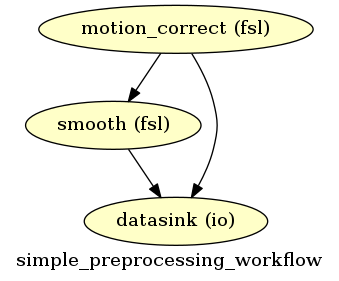

In [11]:
from IPython.display import Image
wf.write_graph(graph2use='colored')
Image(os.path.join('/data/workflow_folders/simple_preprocessing_workflow/graph.png'))

That's looking plain but simple. Now we're ready to run this workflow!

#### Step 4: Running the pipeline, and visualizing results

Running a pipeline can be done by calling the `.run()`-method.

In [12]:
wf.run()

190802-07:03:03,125 nipype.workflow INFO:
	 Workflow simple_preprocessing_workflow settings: ['check', 'execution', 'logging', 'monitoring']
190802-07:03:03,132 nipype.workflow INFO:
	 Running serially.
190802-07:03:03,133 nipype.workflow INFO:
	 [Node] Setting-up "simple_preprocessing_workflow.motion_correct" in "/data/workflow_folders/simple_preprocessing_workflow/motion_correct".
190802-07:03:03,139 nipype.workflow INFO:
	 [Node] Cached "simple_preprocessing_workflow.motion_correct" - collecting precomputed outputs
190802-07:03:03,142 nipype.workflow INFO:
	 [Node] "simple_preprocessing_workflow.motion_correct" found cached.
190802-07:03:03,144 nipype.workflow INFO:
	 [Node] Setting-up "simple_preprocessing_workflow.smooth" in "/data/workflow_folders/simple_preprocessing_workflow/smooth".
190802-07:03:03,150 nipype.workflow INFO:
	 [Node] Cached "simple_preprocessing_workflow.smooth" - collecting precomputed outputs
190802-07:03:03,151 nipype.workflow INFO:
	 [Node] "simple_preproce

After the workflow has finished, let's see what happened. 

We told the DataSink to store everything in this directory: `/data/preprocessed_files`. Using the `tree` in the command line, we can generate a 'directory tree':

In [13]:
!tree /data/preprocessed_files

/data/preprocessed_files
├── motion_corrected_data
│   └── sub-197_task-SAT_run-1_bold_mcf.nii.gz
└── smoothed_data
    └── sub-197_task-SAT_run-1_bold_mcf_smooth.nii.gz

2 directories, 2 files


Alright, so we found the motion corrected data and the smoothed data. First, let's see if the data is actually smoothed. We can do this by comparing the raw data with the output data.

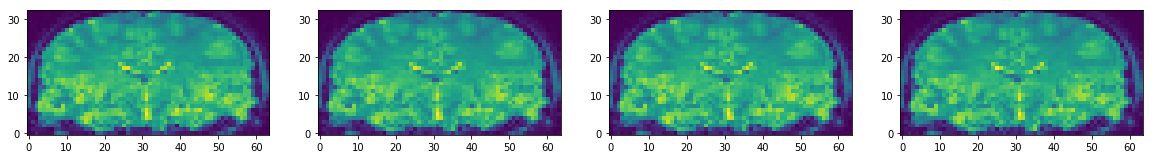

In [14]:
# First, plot a slice of four volumes of the raw data
hdr = nib.load('/data/bids/sub-197/func/sub-197_task-SAT_run-1_bold.nii.gz')
data = hdr.get_data()
f, ax = plt.subplots(nrows=1, ncols=4)
ax[0].imshow(data[:,40,:,10].T, origin='lower')
ax[1].imshow(data[:,40,:,30].T, origin='lower')
ax[2].imshow(data[:,40,:,50].T, origin='lower')
ax[3].imshow(data[:,40,:,80].T, origin='lower')
f.set_size_inches(h=5, w=20)

Now, let's look at exactly the same volumes & slices of the output data

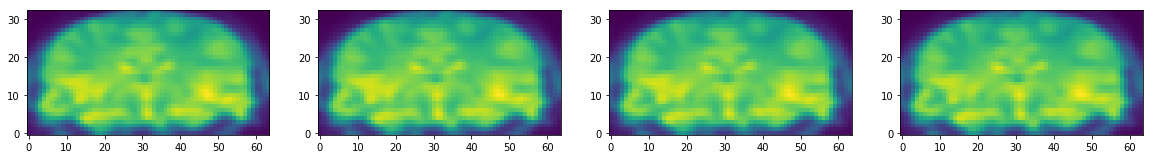

In [15]:
hdr = nib.load('/data/preprocessed_files/smoothed_data/sub-197_task-SAT_run-1_bold_mcf_smooth.nii.gz')
data = hdr.get_data()
f, ax = plt.subplots(nrows=1, ncols=4)
ax[0].imshow(data[:,40,:,10].T, origin='lower')
ax[1].imshow(data[:,40,:,30].T, origin='lower')
ax[2].imshow(data[:,40,:,50].T, origin='lower')
ax[3].imshow(data[:,40,:,80].T, origin='lower')
f.set_size_inches(h=5, w=20)

Clearly, smoothing worked! How about the motion correction?

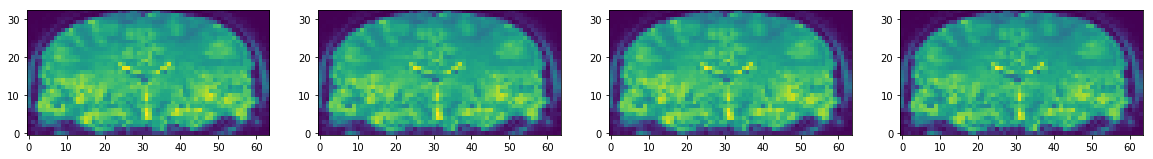

In [16]:
hdr = nib.load('/data/preprocessed_files/motion_corrected_data/sub-197_task-SAT_run-1_bold_mcf.nii.gz')
data = hdr.get_data()
f, ax = plt.subplots(nrows=1, ncols=4)
ax[0].imshow(data[:,40,:,10].T, origin='lower')
ax[1].imshow(data[:,40,:,30].T, origin='lower')
ax[2].imshow(data[:,40,:,50].T, origin='lower')
ax[3].imshow(data[:,40,:,80].T, origin='lower')
f.set_size_inches(h=5, w=20)

Okay, it doesn't seem obviously _wrong_, but it's hard to see any difference from the raw data. Usually, when you call FSL's MCFLIRT, you can also plot the motion parameters, which help you inspect whether there was any excessive motion. Our pipeline currently doesn't plot these parameters. So let's try to adapt our workflow to have it _also_ plot some motion parameters.

#### Extending the simple pipeline to include a motion parameter plotter

In [17]:
from nipype.interfaces.fsl import PlotMotionParams

# Create nodes
mc = Node(MCFLIRT(dof=6, save_plots=True), name='motion_correct')  
# Note that we now explicitly ask MCFLIRT to save motion parameters by entering `save_plots=True`

smoother = Node(IsotropicSmooth(fwhm=6), name='smooth') # same as before
motion_plotter = Node(PlotMotionParams(in_source='fsl', plot_type='translations'), name='motion_plot') # this is new!
ds = Node(DataSink(base_directory='/data/preprocessed_files_wf2'), name='datasink') # same as before

# Create pipeline
wf2 = Workflow(name='simple_preprocessing_workflow2', 
               base_dir='/data/workflow_folders')

# Connect nodes
wf2.connect(mc, 'out_file', smoother, 'in_file') # this is the same as before
wf2.connect(mc, 'out_file', ds, 'motion_corrected_data')  # also the same as before 

# Here, we pass the motion parameters from mc to the motion parameter plotter
wf2.connect(mc, 'par_file', motion_plotter, 'in_file')  
wf2.connect(smoother, 'out_file', ds, 'smoothed_data')
wf2.connect(motion_plotter, 'out_file', ds, 'motion_plots')
# Here, we tell the workflow to make sure that the out_file of the smoother is ported to the DataSink, 
# which saves it in a folder called "smoothed_data"

# Tell the motion correction node what the input file is
mc.inputs.in_file = '/data/bids/sub-197/func/sub-197_task-SAT_run-1_bold.nii.gz'

Let's visualize the workflow we built

190802-07:03:19,693 nipype.workflow INFO:
	 Generated workflow graph: /data/workflow_folders/simple_preprocessing_workflow2/graph.png (graph2use=colored, simple_form=True).


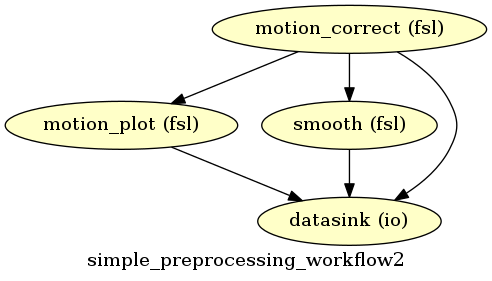

In [18]:
wf2.write_graph(graph2use='colored')
Image('/data/workflow_folders/simple_preprocessing_workflow2/graph.png')

Looks good, so let's run!

In [19]:
wf2.run()

190802-07:03:21,734 nipype.workflow INFO:
	 Workflow simple_preprocessing_workflow2 settings: ['check', 'execution', 'logging', 'monitoring']
190802-07:03:21,744 nipype.workflow INFO:
	 Running serially.
190802-07:03:21,746 nipype.workflow INFO:
	 [Node] Setting-up "simple_preprocessing_workflow2.motion_correct" in "/data/workflow_folders/simple_preprocessing_workflow2/motion_correct".
190802-07:03:21,751 nipype.workflow INFO:
	 [Node] Cached "simple_preprocessing_workflow2.motion_correct" - collecting precomputed outputs
190802-07:03:21,752 nipype.workflow INFO:
	 [Node] "simple_preprocessing_workflow2.motion_correct" found cached.
190802-07:03:21,753 nipype.workflow INFO:
	 [Node] Setting-up "simple_preprocessing_workflow2.motion_plot" in "/data/workflow_folders/simple_preprocessing_workflow2/motion_plot".
190802-07:03:21,756 nipype.workflow INFO:
	 [Node] Cached "simple_preprocessing_workflow2.motion_plot" - collecting precomputed outputs
190802-07:03:21,758 nipype.workflow INFO:
	 

Using the command line command `tree`, we can see the output of this pipeline

In [20]:
!tree /data/preprocessed_files_wf2/

/data/preprocessed_files_wf2/
├── motion_corrected_data
│   └── sub-197_task-SAT_run-1_bold_mcf.nii.gz
├── motion_plots
│   └── sub-197_task-SAT_run-1_bold_mcf.nii.gz_trans.png
└── smoothed_data
    └── sub-197_task-SAT_run-1_bold_mcf_smooth.nii.gz

3 directories, 3 files


And we can load the image here

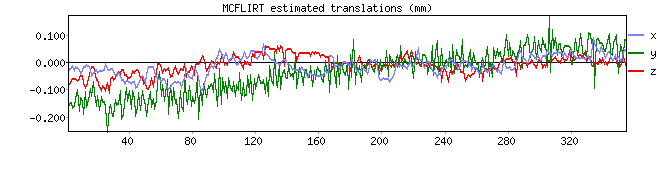

In [21]:
Image('/data/preprocessed_files_wf2/motion_plots/sub-197_task-SAT_run-1_bold_mcf.nii.gz_trans.png')

### Optional exercises to get the hang of building Workflows
Above, the basic concepts of building Nipype workflows were introduced. Now, let's try to see if you can expand the workflow we created before. Try to do the following:

1. The `MotionPlotter`-interface in `wf2` only plots translations. Can you extend the workflow to also plot rotations?
2. Extend `wf2` to *start* with a SliceTimer() FSL-interface (assume that slices were acquired in interleaved order with a TR of 2)
3. Extend `wf2` to *start* with a node that removes the first 5 volumes (you can use the ExtractROI()-interface)

In [ ]:
# your code here

In [ ]:
# your code here

In [ ]:
# your code here

## Pre-configured pipelines & iterating over subjects
You don't always have to do *everything* yourself. Nipype comes with pre-configured preprocessing workflows, developed by the neuroimaging community. (Note that the disadvantages of `fmriprep` also apply here, except that it's maybe easier to adapt one of Nipype's pre-configured pipelines than it is to adapt `fmriprep`)

Here, we use a pre-configured FSL preprocessing pipeline. The goal here is mostly to show you that these exist, and use them to illustrate a *very* useful feature: automatically looping over subjects.

In [22]:
from nipype.workflows.fmri.fsl import create_featreg_preproc  # here we import a function that creates a workflow
import nipype.interfaces.io as nio  # useful

# create_featreg_preproc is a function that creates a preprocessing pipeline (or 'workflow') for fmri-data
preproc_workflow = create_featreg_preproc()

# Nipype workflows require a directory where it can temporary store files (used as a cache). We define this here
preproc_workflow.base_dir = '/data/workflow_folders'

# Set up smoothing (to 0) and highpass filtering at 64 seconds
TR = 1.994
preproc_workflow.inputs.inputspec.fwhm = 0.0
preproc_workflow.inputs.inputspec.highpass = 64 / TR

Let's visualize the workflow `preproc_workflow`

190802-07:03:32,256 nipype.workflow INFO:
	 Generated workflow graph: /data/workflow_folders/featpreproc/graph.png (graph2use=colored, simple_form=True).


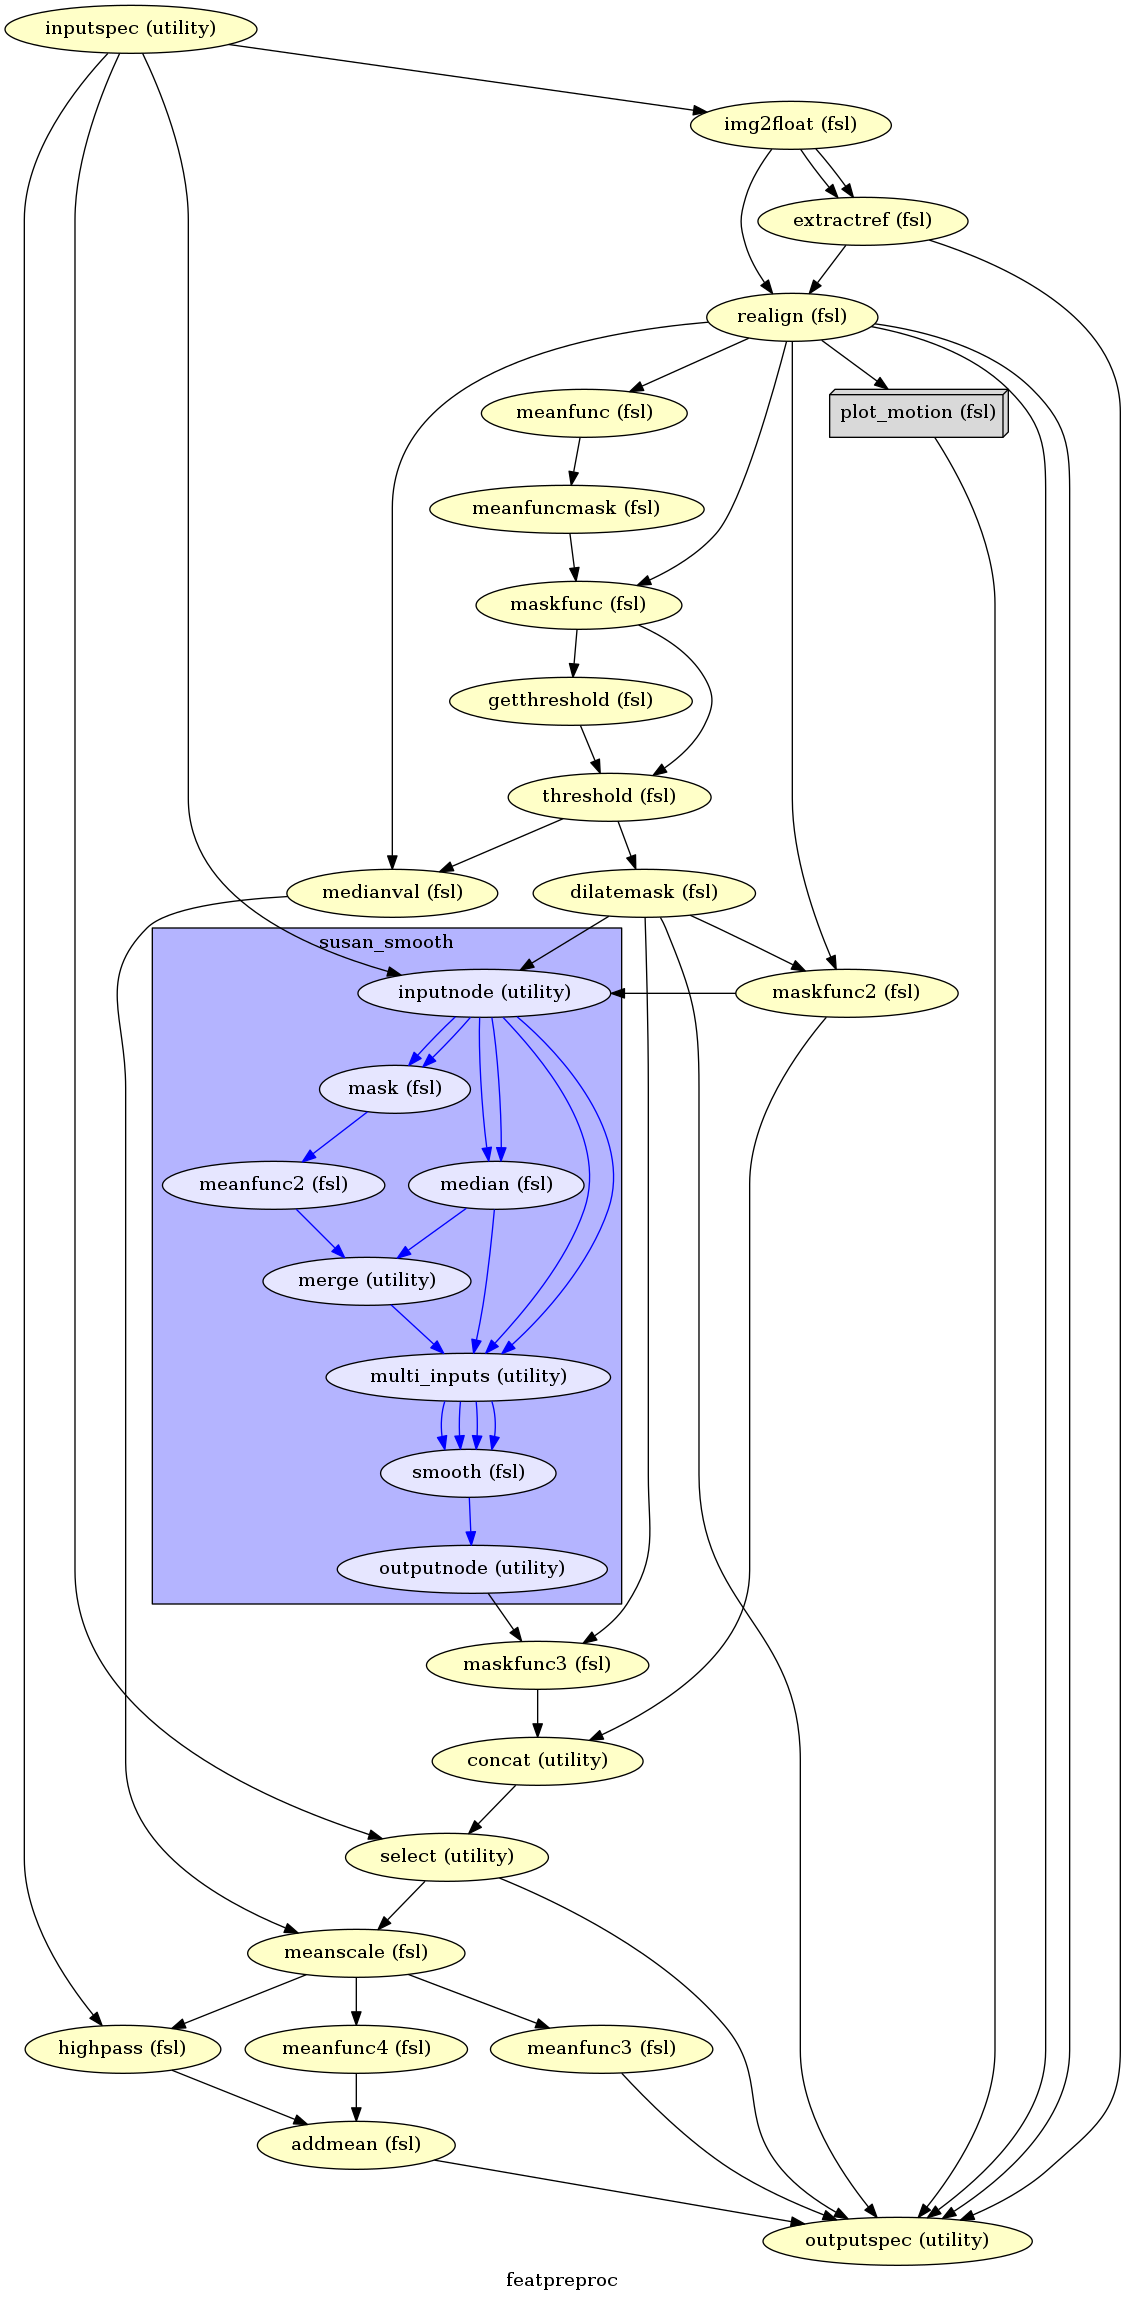

In [23]:
from IPython.display import Image
preproc_workflow.write_graph(graph2use='colored', )
Image('/data/workflow_folders/featpreproc/graph.png')

That's a bit more complex than we did before. It handles realigning (=motion correction), spatial smoothing, and high-pass filtering (NB: no registration).


I'm including this pipeline to illustrate how to easily tell `Nipype` to run this pipeline *for all subjects*. Crucial for this is to understand the _data structure_. These are the directories that contain the 'raw' fMRI files.

In [35]:
!tree /data/bids/

/data/bids/
├── behavior.tsv
├── dataset_description.json
├── sub-197
│   ├── anat
│   │   └── sub-197_T1w.nii.gz
│   └── func
│       ├── sub-197_task-SAT_run-1_bold.nii.gz
│       ├── sub-197_task-SAT_run-1_events.tsv
│       ├── sub-197_task-SAT_run-2_bold.nii.gz
│       └── sub-197_task-SAT_run-2_events.tsv
├── sub-372
│   ├── anat
│   │   └── sub-372_T1w.nii.gz
│   └── func
│       ├── sub-372_task-SAT_run-1_bold.nii.gz
│       ├── sub-372_task-SAT_run-1_events.tsv
│       ├── sub-372_task-SAT_run-2_bold.nii.gz
│       └── sub-372_task-SAT_run-2_events.tsv
├── sub-381
│   ├── anat
│   │   └── sub-381_T1w.nii.gz
│   └── func
│       ├── sub-381_task-SAT_run-1_bold.nii.gz
│       ├── sub-381_task-SAT_run-1_events.tsv
│       ├── sub-381_task-SAT_run-2_bold.nii.gz
│       └── sub-381_task-SAT_run-2_events.tsv
├── sub-471
│   ├── anat
│   │   └── sub-471_T1w.nii.gz
│   └── func
│       ├── sub-471_task-SAT_run-1_bold.nii.gz
│       ├── sub-471_task-SAT_run-1_events.tsv
│       ├── sub

In [24]:
!ls /data/bids/sub-197

anat  func


In [25]:
!ls /data/bids/sub-197/func

sub-197_task-SAT_run-1_bold.nii.gz  sub-197_task-SAT_run-2_bold.nii.gz
sub-197_task-SAT_run-1_events.tsv   sub-197_task-SAT_run-2_events.tsv


In order to have Nipype automagically loop over these subjects, we have to make a template of what the functional files look like.  Have a look at the documentation for the [SelectFiles-interface](https://nipype.readthedocs.io/en/latest/users/select_files.html)

Try to complete the template

In [38]:
 # fill in
templates = {'func': '/data/bids/ .... _run-*_bold.nii.gz'}  # complete the template

# The * is a so-called wildcard - you can forget about it for now, but leave it in the string

Now, we're creating a Node with a SelectFiles-interface. We tell the SelectFiles-interface what the template is

In [ ]:
selector = Node(nio.SelectFiles(templates), name='selector')

We connect this new selector node right to the start of the preproc-workflow. Note that the entrynode of the preproc-workflow was called "inputspec". Using `preproc_workflow.get_node("inputspec")`, we can make sure to connect the Selector to this Node

In [ ]:
preproc_workflow.connect(selector, 'func', preproc_workflow.get_node("inputspec"), 'func')

We need to tell the selector how to iterate over subjects. In other words: what values should be filled in 'subject_id' as defined in the template?

In [ ]:
# add the first four subject IDs
selector.iterables = [('subject_id', ['197', ...])] # add the IDs

Finally, like before, let's set-up a datasink to save the high-pass filtered data and mean data to an output filder

In [ ]:
ds = Node(nio.DataSink(), name='datasink')
ds.inputs.base_directory = '/data/preprocessed_data'

In [ ]:
preproc_workflow.connect(preproc_workflow.get_node("outputspec"), 'highpassed_files', ds, 'highpassed_files')
preproc_workflow.connect(preproc_workflow.get_node("outputspec"), 'mean', ds, 'mean')

Now we can visualize the workflow one more time to see what we just did.

In [60]:
from IPython.display import Image
preproc_workflow.write_graph(graph2use='colored')
Image('/data/workflow_folders/featpreproc/graph.png')

OSError: Could not create directory /data/workflow_folders/featpreproc

Compare the start & end of this graph with the previous graph

And we're ready to run! As a final note, it's very easy to run the pipeline in parallel on multiple processes, like this:

In [ ]:
preproc_workflow.run(plugin='MultiProc', plugin_args={'n_procs' : 3})

Can you visualize the output using `tree`?

# Additional resources

The above tutorial is meant to give you a taste of how to do pre-processing with Nypipe. An excellent, more in-depth tutorial on how to use Nypipe can be found here:
https://miykael.github.io/nipype_tutorial/

For the remainder of this tutorial, we will work with data preprocessed using fmriprep